In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import BaseEstimator, RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Converting Times Series Data to 3D format
from src.utils.split_sequences import split_sequences

2024-10-12 11:14:07.384516: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-12 11:14:07.388149: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 11:14:07.450279: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 11:14:07.451609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 11:14:08.539431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<IPython.core.display.Javascript object>

# Functions and definitions

## Helper functions for blocked time series cross validation

### Convert train/test data to 3D format

In [3]:
def generate_sequences_helper(
    dataset, cement_types, dates=None, timesteps=None, split_by_cement_type=False
):
    index_train = dataset["y_train"].index
    index_test = dataset["y_test"].index

    dataset["y_train"] = dataset["y_train"].reset_index(drop=True)
    dataset["y_test"] = dataset["y_test"].reset_index(drop=True)

    if dates is not None:
        dataset["dates_train"] = dates[index_train].reset_index(drop=True)
        dataset["dates_test"] = dates[index_test].reset_index(drop=True)

    dataset["cement_types_train"] = cement_types.loc[index_train].reset_index(drop=True)
    dataset["cement_types_test"] = cement_types.loc[index_test].reset_index(drop=True)

    dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

    return dataset

<IPython.core.display.Javascript object>

In [4]:
def generate_sequences(dataset, timesteps, split_by_cement_type=False):
    if split_by_cement_type:
        dataset["x_train"], dataset["y_train"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_train"],
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["cement_types_train"],
                    dataset["y_train"],
                ],
                axis=1,
            ),
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_test"],
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["cement_types_test"],
                    dataset["y_test"],
                ],
                axis=1,
            ),
            timesteps,
        )
    else:
        dataset["x_train"], dataset["y_train"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["y_train"],
                ],
                axis=1,
            ).values,
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["y_test"],
                ],
                axis=1,
            ).values,
            timesteps,
        )
    return dataset

<IPython.core.display.Javascript object>

### Data preprocessing

In [5]:
def impute_data(dataset, imputer=None, imputer_params=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply imputation to the data
    if imputer is not None:
        imputer = imputer() if imputer_params is None else imputer(**imputer_params)
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return dataset

<IPython.core.display.Javascript object>

In [6]:
def transform_data(dataset, transformer=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply data normalization/standardization to the data
    if transformer is not None:
        scaler = transformer()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return dataset

<IPython.core.display.Javascript object>

In [7]:
def preprocess_data(dataset, transformer=None, imputer=None, imputer_params=None):
    dataset = impute_data(dataset, imputer, imputer_params)
    dataset = transform_data(dataset, transformer)
    return dataset

<IPython.core.display.Javascript object>

### Train and evaluate the model

In [8]:
def train_and_evaluate_model(Estimator, dataset, estimator_params={}):
    """
    Purpose: Helper function to be used in conjunction with
    blocked time_series cross validation function
    """
    x_train = dataset["x_train"]
    y_train = dataset["y_train"]
    x_test = dataset["x_test"]
    y_test = dataset["y_test"]

    # Instantiate the model
    model = Estimator() if estimator_params is None else Estimator(estimator_params)

    # Fitting the model
    model.fit(x_train, y_train)

    # Making predictions on train/test sets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Return regression metrics
    return score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

<IPython.core.display.Javascript object>

### Custom Cross Validate

In [9]:
def custom_cross_validate(
    Estimator,
    Imputer,
    Transform,
    x,
    y,
    cv,
    timesteps,
    dates=None,
    cement_types=None,
    estimator_params={},
    imputer_params=None,
    split_by_cement_type=True,
):
    results = []
    scores = []

    for train_index, test_index in cv.split(x):
        dataset = {
            "dates_train": dates[train_index].reset_index(drop=True),
            "cement_types_train": cement_types.loc[train_index].reset_index(drop=True),
            "x_train": x.loc[train_index].reset_index(drop=True),
            "y_train": y[train_index].reset_index(drop=True),
            "dates_test": dates[test_index].reset_index(drop=True),
            "cement_types_test": cement_types.loc[test_index].reset_index(drop=True),
            "x_test": x.loc[test_index].reset_index(drop=True),
            "y_test": y[test_index].reset_index(drop=True),
        }

        # Preprocess the dataset
        dataset = preprocess_data(dataset, Transform, Imputer, imputer_params)

        # generate sequences (3D format)
        dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

        # Train and Evaluate the model
        score = train_and_evaluate_model(Estimator, dataset, estimator_params)
        scores.append(score)

    # After every iteration metrics results are appended together
    scores_final = {key: [] for key, _ in scores[0].items()}
    for scores_dict in scores:
        for key, value in scores_dict.items():
            scores_final[key] += [value]
    results.append(scores_final)
    return results

<IPython.core.display.Javascript object>

## Model Definition

In [10]:
class BidirectionalLSTM(BaseEstimator, RegressorMixin):
    def __init__(self, params={}):
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = params.get("verbose", 0)
        self.callbacks = params.get("callbacks", None)
        self.validation_split = params.get("validation_split", None)

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = tf.keras.Sequential()
        model.add(
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(units=128, activation="elu", return_sequences=True)
            )
        )
        model.add(
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(units=64, activation="elu")
            )
        )
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

<IPython.core.display.Javascript object>

In [11]:
def pad_time_series(dataframe, timesteps):
    """
    Pad timeseries with zeros
    """
    df_tmp = pd.DataFrame(
        dict(
            zip(
                dataframe.columns,
                [[0 for _ in range(timesteps - 1)] for _ in range(dataframe.shape[1])],
            )
        )
    )
    df_tmp[DATE] = dataframe[DATE].iloc[0]
    return pd.concat([df_tmp, dataframe], axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [12]:
def split_sequences_per_cement_type(dataframe, timesteps, pad=False):
    """
    Create sequences per cement time
    to avoid having parts of the sequence
    of different types of cement.
    """
    if timesteps == 1:
        return split_sequences(
            dataframe.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps
        )

    dates = dataframe[DATE][timesteps - 1 :]
    data = []
    dataframes = []

    for cement_type in CEMENT_TYPES:
        data.append(dataframe[dataframe[cement_type] == 1])
    data.append(dataframe[(dataframe[CEMENT_TYPES] == 0).all(axis=1)])

    for df in data:
        if pad:
            dates = df[DATE].reset_index(drop=True)
            df = pad_time_series(df, timesteps).reset_index(drop=True)
        else:
            dates = df[DATE][timesteps - 1 :].reset_index(drop=True)
        x, y = split_sequences(df.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps)
        x = pd.DataFrame({"Sequences": [sample.tolist() for sample in x]})
        y = pd.DataFrame({"Target": y})
        dataframes.append(pd.concat([dates, x, y], axis=1))

    data = pd.concat(dataframes, axis=0)
    data[DATE] = pd.to_datetime(data[DATE])
    data = data.sort_values(by=DATE).reset_index(drop=True)
    x = data["Sequences"]
    y = data["Target"].values
    x = np.array(x.tolist())
    dates = data[DATE]

    return x, y, dates

<IPython.core.display.Javascript object>

# Settings for Reproducibility

In [13]:
SEED = 47

<IPython.core.display.Javascript object>

In [14]:
def set_seeds(seed=SEED):
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [15]:
def set_global_determinism():
    set_seeds(seed=SEED)

    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

<IPython.core.display.Javascript object>

In [16]:
index_to_save = 10

<IPython.core.display.Javascript object>

In [17]:
weights_path = "../../../../../../../models/global_models/inn/bi-lstm/inn/pre_training/"
model_name = "BidirectionalLSTM_chemical_properties_csless_vars_weights.h5"
full_path = os.path.join(weights_path, model_name)

<IPython.core.display.Javascript object>

In [18]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}
DATE = "Date"
CEMENT_TYPES = [
    "Cement_Type_Type III",
    "Cement_Type_Type IL",
]

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [19]:
results_to_save = []

results_dict = {
    "Category": "Global Model",
    "Company": "partner_ii",
    "Plant": "partner_ii",
    "Features": "Chemical + Properties CS Less",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "BidirectionalLSTM",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [20]:
df = pd.read_csv(
    "../../../../../../../data/processed/partner_ii/cement-shipping_fine_tuning.csv"
)

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [21]:
df_copy = df.copy()
df_copy = pd.get_dummies(data=df_copy, columns=["Cement_Type"], drop_first=True)

df_copy = df_copy.drop(
    [
        "Factory_Plant",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we use all available features

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [22]:
df_copy[CEMENT_TYPES] = df_copy[CEMENT_TYPES].astype(int)
dates = df["Date"].copy()
y = df_copy.pop("CS28")
x = df_copy
df_copy = pd.concat([x, y], axis=1)

<IPython.core.display.Javascript object>

In [23]:
TIMESTEPS_LIST = [7]

<IPython.core.display.Javascript object>

# 1. Long Short Term Memory - BidirectionalLSTM

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Timesteps:</b> 1, 3, 5, 7, 10, 15, 20<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 123 samples each
    2. 90% train (1111 samples each fold)
    3. 10% test (123 samples each fold)
<b>Total:</b> 100 models<br>

In [24]:
# start = time.time()

# repeats = 3
# n_splits = 5
# TIMESTEPS_LIST = [7]

# print("Repeated Cross Validation:")
# print(f"Repeats: {repeats}")
# print(f"n_splits: {n_splits}")
# print()

# for timesteps in TIMESTEPS_LIST:
#     set_seeds()
#     cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
#     x = df_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
#     y = df_copy["CS28"]
#     scores = custom_cross_validate(
#         BidirectionalLSTM,
#         SimpleImputer,
#         StandardScaler,
#         x,
#         y,
#         cv,
#         timesteps=timesteps,
#         dates=dates,
#         cement_types=df_copy[CEMENT_TYPES],
#         estimator_params={},
#         imputer_params={"strategy": "median"},
#         split_by_cement_type=True,
#     )
#     scores = scores[0]
#     print("TIMESTEPS: %d " % timesteps)
#     print_scores(scores, METRICS, METRICS_DICT)

#     results_dict_copy = results_dict.copy()
#     results_dict_copy["Timesteps"] = timesteps
#     results_dict_copy["Cross Validation"] = "Repeated KFold"
#     results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
#     results_dict_copy["Data Shape"] = x.shape
#     df_results = fill_results_dict(results_dict_copy, scores)
#     results_to_save.append(df_results)

# end = time.time()
# print("Minutes Elapsed: ", (end - start) / 60)

<IPython.core.display.Javascript object>

In [25]:
# pd.concat(results_to_save).reset_index().groupby(
#     ["Features", "Model", "Cross Validation", "Timesteps"], dropna=False
# )[["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]].agg(
#     ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
# ).reset_index().rename(
#     columns={"<lambda_0>": "std"}
# )

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [26]:
# start = time.time()

# repeats = 3
# n_splits = 5
# train_size = 0.8
# TIMESTEPS_LIST = [7]

# print("Blocking Time Series Split:")
# print(f"Repeats: {repeats}")
# print(f"n_splits: {n_splits}")
# print()

# for timesteps in TIMESTEPS_LIST:
#     set_seeds()
#     scores_final = None

#     for _ in range(repeats):
#         x = df_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
#         y = df_copy["CS28"]

#         cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)

#         scores = custom_cross_validate(
#             BidirectionalLSTM,
#             SimpleImputer,
#             StandardScaler,
#             x,
#             y,
#             cv,
#             timesteps,
#             dates=dates,
#             cement_types=df_copy[CEMENT_TYPES],
#             estimator_params={},
#             imputer_params={"strategy": "median"},
#             split_by_cement_type=True,
#         )
#         scores = scores[0]
#         if scores_final is None:
#             scores_final = {key: [] for key, _ in scores.items()}

#         for key, value in scores.items():
#             scores_final[key] += [value]

#     print("TIMESTEPS: %d " % timesteps)
#     print_scores(scores_final, METRICS, METRICS_DICT)

#     # Saving the results
#     scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
#     results_dict_copy = results_dict.copy()
#     results_dict_copy["Timesteps"] = timesteps
#     results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
#     results_dict_copy[
#         "Cross Validation Params"
#     ] = '{"N_Splits": 5, "Repeats": 3, "train_size": 0.8}'
#     results_dict_copy["Data Shape"] = x.shape
#     df_results = fill_results_dict(results_dict_copy, scores)
#     results_to_save.append(df_results)

# end = time.time()
# print("Minutes Elapsed: ", (end - start) / 60)

<IPython.core.display.Javascript object>

In [27]:
# pd.concat(results_to_save).reset_index().groupby(
#     ["Features", "Model", "Cross Validation", "Timesteps"], dropna=False
# )[["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]].agg(
#     ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
# ).reset_index().rename(
#     columns={"<lambda_0>": "std"}
# )

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i th split, with a test set of size n_samples//(n_splits + 1) by default, where n_samples is the number of samples.


<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>10<br>    
    1. Train: 10 folds of 114, 226, 338, 450, 562, 675, 787, 899, 1011, 1123 samples each fold
    2. Test: 112 samples each fold
<b>Total:</b> 10 models<br>

In [28]:
# set_seeds()
# start = time.time()
# gap = 0
# n_splits = 5
# repeats = 3
# TIMESTEPS_LIST = [7]

# print("Blocking Time Series Split:")
# print(f"Repeats: {repeats}")
# print(f"n_splits: {n_splits}")
# print()

# for timesteps in TIMESTEPS_LIST:
#     set_seeds()
#     scores_final = None

#     for _ in range(repeats):
#         x = df_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
#         y = df_copy["CS28"]

#         cv = TimeSeriesSplit(
#             gap=gap, max_train_size=None, n_splits=n_splits, test_size=None
#         )
#         scores = custom_cross_validate(
#             BidirectionalLSTM,
#             SimpleImputer,
#             StandardScaler,
#             x,
#             y,
#             cv,
#             timesteps,
#             dates=dates,
#             cement_types=df_copy[CEMENT_TYPES],
#             estimator_params={},
#             imputer_params={"strategy": "median"},
#         )
#         scores = scores[0]
#         if scores_final is None:
#             scores_final = {key: [] for key, _ in scores.items()}

#         for key, value in scores.items():
#             scores_final[key] += [value]

#     print("TIMESTEPS: %d " % timesteps)
#     print_scores(scores_final, METRICS, METRICS_DICT)

#     # Saving the results
#     scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
#     results_dict_copy = results_dict.copy()
#     results_dict_copy["Timesteps"] = timesteps
#     results_dict_copy["Cross Validation"] = "Time Series Split"
#     results_dict_copy[
#         "Cross Validation Params"
#     ] = '{"N_Splits": 5, "Repeats": 3, "Gap": 0}'
#     results_dict_copy["Data Shape"] = x.shape
#     df_results = fill_results_dict(results_dict_copy, scores)
#     results_to_save.append(df_results)

# end = time.time()
# print("Minutes Elapsed: ", (end - start) / 60)

<IPython.core.display.Javascript object>

In [29]:
# pd.concat(results_to_save).reset_index().groupby(
#     ["Features", "Model", "Cross Validation", "Timesteps"], dropna=False
# )[["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]].agg(
#     ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
# ).reset_index().rename(
#     columns={"<lambda_0>": "std"}
# )

<IPython.core.display.Javascript object>

## 1.4. Out of time Split Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Train size: 80%</b><br>
<b>Test  size: 20%</b>


<b>Splits:</b> 2<br>    
    1. Train: 987
    2. Test: 247
<b>Total:</b> 1 model<br>

In [30]:
start = time.time()
test_size = 0.5
repeats = 3
TIMESTEPS_LIST = [7]
preds = {}

print("Out of time Cross Val:")
print(f"Repeats: {repeats}")
print(f"Train: {50}%", f"Test: {50}%")
print()

for timesteps in TIMESTEPS_LIST:
    set_seeds()
    scores_final = None

    for repeat in range(repeats):
        set_seeds(SEED + repeat)
        # Data Splitting
        x = df_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
        y = df_copy["CS28"]

        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size, random_state=SEED, shuffle=False
        )
        # Preprocessing
        imputer = SimpleImputer(strategy="median")
        scaler = StandardScaler()

        x_train = imputer.fit_transform(x_train)
        x_train = scaler.fit_transform(x_train)
        dates_train = dates[: x_train.shape[0]].reset_index(drop=True)
        cement_types_train = df_copy[CEMENT_TYPES][: x_train.shape[0]].reset_index(
            drop=True
        )

        x_test = imputer.transform(x_test)
        x_test = scaler.transform(x_test)
        dates_test = dates[x_train.shape[0] :].reset_index(drop=True)
        cement_types_test = df_copy[CEMENT_TYPES][x_train.shape[0] :].reset_index(
            drop=True
        )

        # Sequence Splitting
        data_train = pd.concat(
            [
                dates_train,
                pd.DataFrame(x_train, columns=x.columns),
                cement_types_train,
                y_train.reset_index(drop=True),
            ],
            axis=1,
        )
        data_test = pd.concat(
            [
                dates_test,
                pd.DataFrame(x_test, columns=x.columns),
                cement_types_test,
                y_test.reset_index(drop=True),
            ],
            axis=1,
        )

        x_train, y_train, dates_train_filter = split_sequences_per_cement_type(
            data_train, timesteps
        )
        x_test, y_test, dates_test_filter = split_sequences_per_cement_type(
            data_test, timesteps
        )

        # Train model and test evalutation
        # Fit model
        pipeline = Pipeline([("estimator", BidirectionalLSTM(params={}))])
        pipeline.fit(x_train, y_train)

        # Make predictions
        y_train_pred = pipeline.predict(x_train)
        y_test_pred = pipeline.predict(x_test)

        # evaluate predictions
        scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

        if scores_final is None:
            scores_final = {key: [] for key, _ in scores.items()}

        for key, value in scores.items():
            scores_final[key] += [value]

        preds[repeat + 1] = {
            "pipeline": pipeline,
            "dates_train": dates_train_filter,
            "dates_test": dates_test_filter,
            "x_train": x_train,
            "x_test": x_test,
            "y_train": y_train,
            "y_test": y_test,
            "y_train_pred": y_train_pred,
            "y_test_pred": y_test_pred,
        }

    print("TIMESTEPS: %d " % timesteps)
    print_scores(scores_final, METRICS, METRICS_DICT)

    # Saving the results
    # scores = {key: val[0] for key, val in scores.items()}
    results_dict_copy = results_dict.copy()
    results_dict_copy["Timesteps"] = timesteps
    results_dict_copy["Cross Validation"] = "Out of time Split"
    results_dict_copy["Cross Validation Params"] = '{"Test Size": 0.2}'
    results_dict_copy["Data Shape"] = x.shape
    df_results = fill_results_dict(
        results_dict_copy, {key: value for key, value in scores_final.items()}
    )
    results_to_save.append(df_results)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Out of time Cross Val:
Repeats: 3
Train: 50% Test: 50%



2024-10-12 11:14:13.663288: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-12 11:14:13.663333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: inspirada
2024-10-12 11:14:13.663341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: inspirada
2024-10-12 11:14:13.663527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2024-10-12 11:14:13.663555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2024-10-12 11:14:13.663561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


TIMESTEPS: 7 
******
[TRAIN]
******
RMSE: 1.326 (0.017)
MAE: 1.083 (0.029)
MAPE: 0.026 (0.001)
R2: 0.788 (0.005)


******
[TEST]
******
RMSE: 11.604 (0.076)
MAE: 6.718 (0.068)
MAPE: 0.175 (0.002)
R2: -17.131 (0.237)


Minutes Elapsed:  2.294816283384959


<IPython.core.display.Javascript object>

In [31]:
pd.concat(results_to_save).reset_index().groupby(
    ["Features", "Model", "Cross Validation", "Timesteps"], dropna=False
)[["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
).round(2)


Features              Model   Cross Validation  \
                                                                         
0  Chemical + Properties CS Less  BidirectionalLSTM  Out of time Split   

  Timesteps RMSE Test       MAE Test       MAPE Test      R2 Test        
                 mean   std     mean   std      mean  std    mean   std  
0         7      11.6  0.08     6.72  0.07      0.18  0.0  -17.13  0.24

<IPython.core.display.Javascript object>

In [32]:
dates_test = preds[1]["dates_test"]
y_train = preds[1]["y_train"]
y_test = preds[1]["y_test"]
y_test_pred = []

for repeat in range(repeats):
    y_test_tmp = preds[repeat + 1]["y_test_pred"]
    y_test_pred.append(y_test_tmp)

y_test_pred = np.mean(np.array(y_test_pred), axis=0)
x_test = preds[1]["x_test"]
filtered_dates = dates_test

test_data = pd.DataFrame(
    {
        "Date": pd.to_datetime(filtered_dates),
        "CS28": y_test.squeeze(),
        "CS28_PRED": y_test_pred.squeeze(),
    }
)

<IPython.core.display.Javascript object>

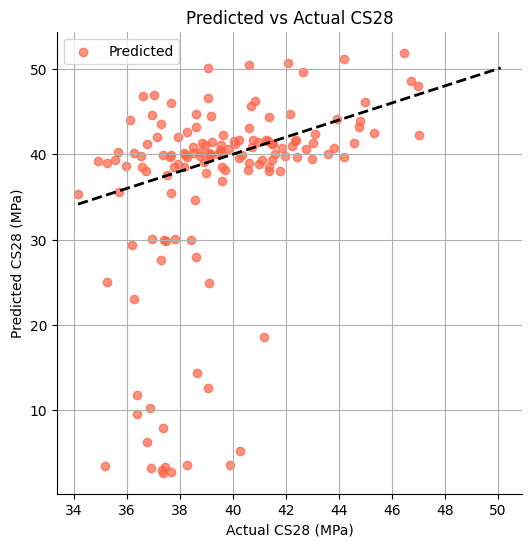

<IPython.core.display.Javascript object>

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [y.min(), y.max()],
    [y.min(), y.max()],
    color="black",
    linestyle="--",
    linewidth=2,
)

plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_partner_iv_global_fine_tuning_cm_p_bi-lstm_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

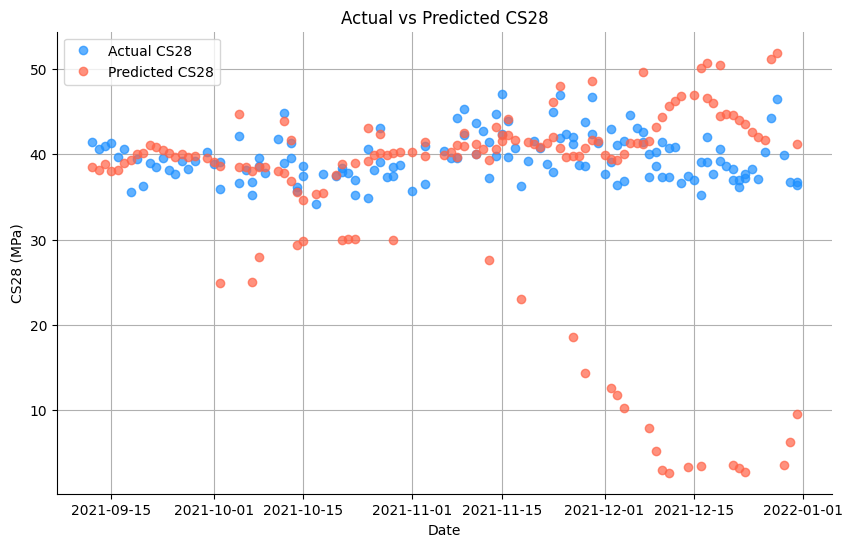

<IPython.core.display.Javascript object>

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["Date"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["Date"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_partner_iv_global_fine_tuning_cm_p_bi-lstm_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [35]:
def permutation_importance_seq(model, X, y, metric, n_repeats=5):
    """
    Computes permutation importance for sequence models with 3D input.
    """
    baseline_score = metric(y, model.predict(X))
    num_features = X.shape[2]  # Number of features
    importances = np.zeros(num_features)
    set_seeds()
    for i in range(num_features):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            # Shuffle feature i across samples, keeping time steps intact
            for t in range(X.shape[1]):
                # Extract the feature values at time t
                feature_values = X_permuted[:, t, i]
                np.random.shuffle(feature_values)
                X_permuted[:, t, i] = feature_values
            # Compute metric with permuted data
            permuted_score = metric(y, model.predict(X_permuted))
            scores.append(permuted_score)
        # Importance is the increase in metric when the feature is permuted
        importances[i] = baseline_score - np.mean(scores)
    return importances

<IPython.core.display.Javascript object>

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tqdm import tqdm

feature_importances = []

for repeat in preds.keys():
    x_test_seq = preds[repeat]["x_test"]
    y_test_seq = preds[repeat]["y_test"]
    estimator = preds[repeat]["pipeline"]

    # Compute permutation importance
    importances = permutation_importance_seq(
        estimator, x_test_seq, y_test_seq, r2_score, n_repeats=10
    )
    feature_importances.append(importances)

<IPython.core.display.Javascript object>

In [37]:
import numpy as np
import pandas as pd

# Average importances across folds
mean_importances = np.mean(feature_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(feature_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


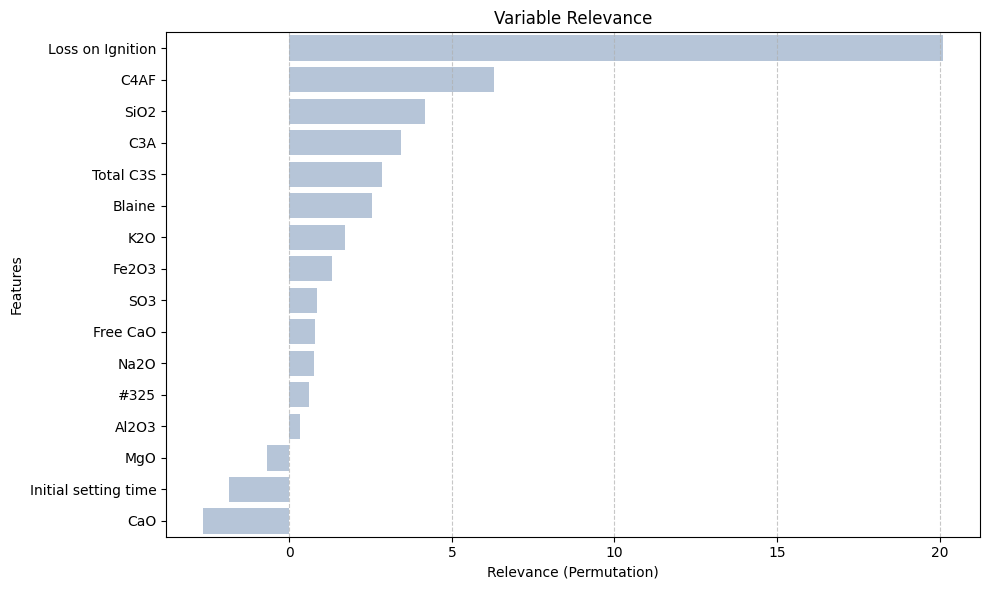

<IPython.core.display.Javascript object>

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(by='Importance', ascending=False).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mean_importances_df, color="lightsteelblue")
plt.title("Variable Relevance")
plt.xlabel("Relevance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(
    "inn_partner_iv_global_fine_tuning_cm_p_bi-lstm_best_mean_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

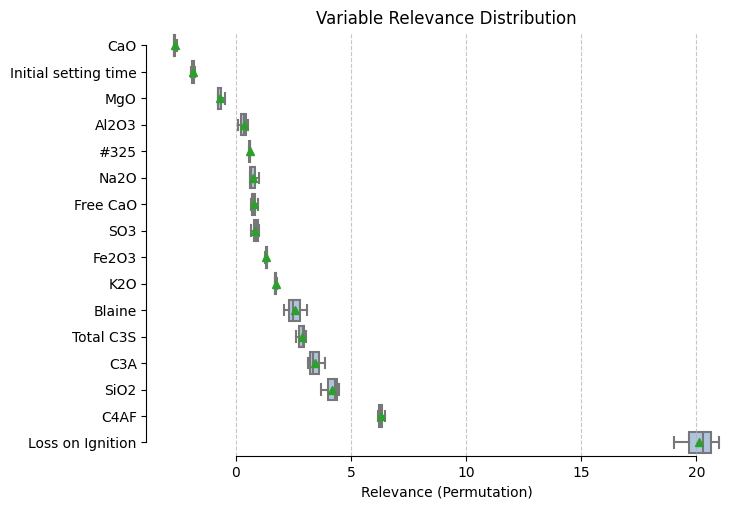

<IPython.core.display.Javascript object>

In [39]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_partner_iv_global_fine_tuning_cm_p_bi-lstm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [40]:
perm_importances_df

,CaO,Initial setting time,MgO,Al2O3,#325,Na2O,Free CaO,SO3,Fe2O3,K2O,Blaine,Total C3S,C3A,SiO2,C4AF,Loss on Ignition
0,-2.567238,-1.871458,-0.762351,0.109831,0.553981,0.640821,0.648500,0.670484,1.336256,1.690225,2.094893,2.598453,3.132871,3.706638,6.261113,19.037205
1,-2.693366,-1.930852,-0.766950,0.362988,0.629158,0.623173,0.739306,0.873282,1.356440,1.683737,2.488547,2.934407,3.352898,4.317248,6.176414,20.286818
2,-2.674554,-1.777426,-0.482933,0.544287,0.615682,0.988617,0.963836,1.017738,1.280369,1.805390,3.083672,3.030294,3.873855,4.468959,6.476392,20.990791


<IPython.core.display.Javascript object>

# Saving the results Dataframe

## Saving the full dataframe

In [41]:
path = (
    f"../../../../../../../reports/results/global_models/inn_v2/partner_iv/fine_tuning/full/"
)
filename = f"BidirectionalLSTM_results_full_{index_to_save}.csv"

pd.concat(results_to_save).to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

In [42]:
cols_groupby = [
    "Category",
    "Company",
    "Data Shape",
    "Timesteps",
    "Features",
    "Model",
    "Cross Validation",
    "Cross Validation Params",
]

cols_agg = ["RMSE Train", "MAE Train", "MAPE Train", "R2 Train"] + [
    "RMSE Test",
    "MAE Test",
    "MAPE Test",
    "R2 Test",
]

path = f"../../../../../../../reports/results/global_models/inn_v2/partner_iv/fine_tuning/grouped/"
filename = f"BidirectionalLSTM_results_grouped_{index_to_save}.csv"


df_results_to_save = (
    pd.concat(results_to_save)
    .groupby(cols_groupby, dropna=False)[cols_agg]
    .agg(["mean", lambda series: pd.Series(series.std(ddof=0), name="std")])
    .reset_index()
    .rename(columns={"<lambda_0>": "std"})
)

df_results_to_save.to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>